<h1> Brain tumor detection using custom CNN models </h1>
<p> In this notebook, multiple <b>CNNs</b> of <b>varying depths</b> have been used to create an <b>image classification network</b> to detect Brain Tumors. Keras API and tensorflow have been used in this notebook. 

<p> In my previous notebooks, I had used transfer learning with various pre-trained models like ResNet50, DenseNet169, etc. to classify the MRI scans . In this notebook, the aim is to classify these images by training CNNs from scratch. I will be using CNNs of varying depths ranging from 2 layered CNNs going all the way up to 8 layered CNNs. The performance of the models will be evaluated on a test set using various metrics like Cohen's Kappa Score, curacy, F1 score, AUC score, etc. </p>

<h2> Importing Necessary Libraries </h2>

In [29]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [30]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy
import os
import shutil
import itertools
import imutils
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


<h2> Creating the required Directory structure</h2>
<p> The dataset contains three folders <dl>
    <dt>yes</dt>
    <dd>This folder contains the MRI scans of the brains which have tumors </dd>
    <dt>no</dt>
    <dd>This folder contains the MRI scans of the brains which do not have a tumor<dd>
    <dt>pred</dt>
    <dd>This folder  ains unlabelled MRI scans</dd>
    </dl></p>
 
<p>For our problem we are not going to use the <b>"pred"</b> folder. </p>
<p> We are going to create three separate folders<ul>
    <li>TRAIN</li>
    <li>TEST</li>
    <li>VAL</li></ul></p>
   
<p>Each of these folder will have two folders : <dl>
    <dt>no</dt>
    <dd>Folder containing negative samples (no brain tumor)</dd>
    <dt>yes</dt>
    <dd>Folder containing positive sample (brain tumor is present</dd></dl></p>
    

In [31]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists
.
├── TEST
│   ├── NO
│   └── YES
├── TEST_CROP
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── TRAIN_CROP
│   ├── NO
│   └── YES
├── VAL
│   ├── NO
│   └── YES
└── VAL_CROP
    ├── NO
    └── YES

18 directories


In [32]:
IMG_PATH = "../input/brain-tumor-detection-mri/Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

<h2> Let's define some helpful functions </h2>

In [33]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [34]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [35]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.68s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|          | 0/2 [00:00<?, ?it/s]

1800 images loaded from TRAIN/ directory.


  0%|          | 0/2 [00:00<?, ?it/s]

600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

600 images loaded from VAL/ directory.


<h2> Plotting the distribution of data in train, test and validation sets</h2>

In [36]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

<h2> Let's visualize the images we are working with </h2>

In [37]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

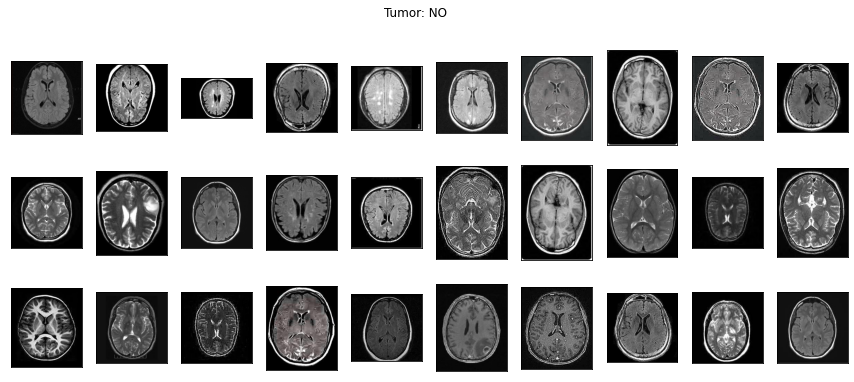

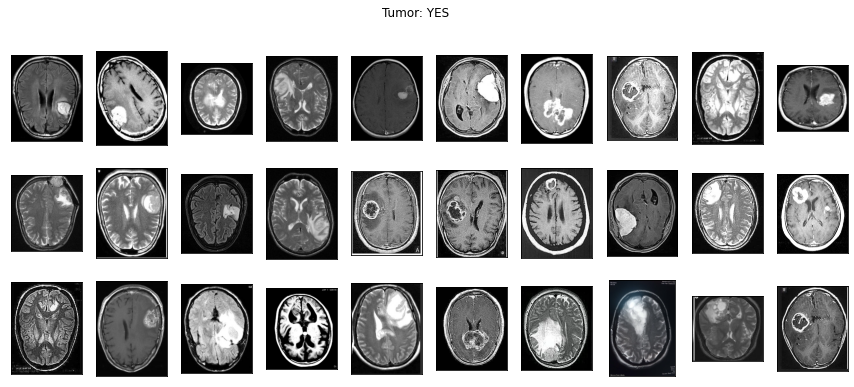

In [38]:
plot_samples(X_train, y_train, labels, 30)

<h2> Cropping the images</h2>
<p>The images we have are of different sizes. But our model accepts images of size (224*224*3) as input. To achienve this ew have to resize the images. Blindly resizing the images can lead to extreme distortions in the images. Hence, We will first crop thie images and then resize them. This will minimize the issue of distortions.</p>
<p>This cropping is done by finding contours in the images using the OpenCV Library</p>    

In [39]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [40]:
import imutils
img = cv2.imread('./VAL/NO/no852.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

<h2> Let's visulaize the cropping process step by step </h2>

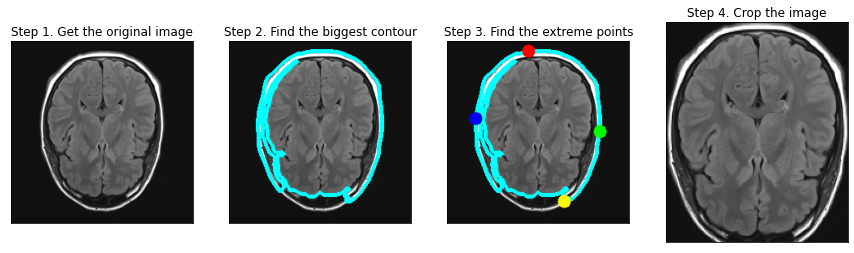

In [41]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [42]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



<h2>Let's visualize the images after being cropped</h2>

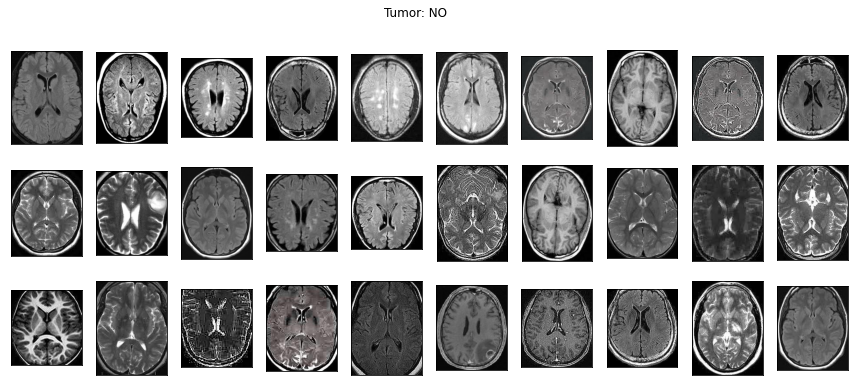

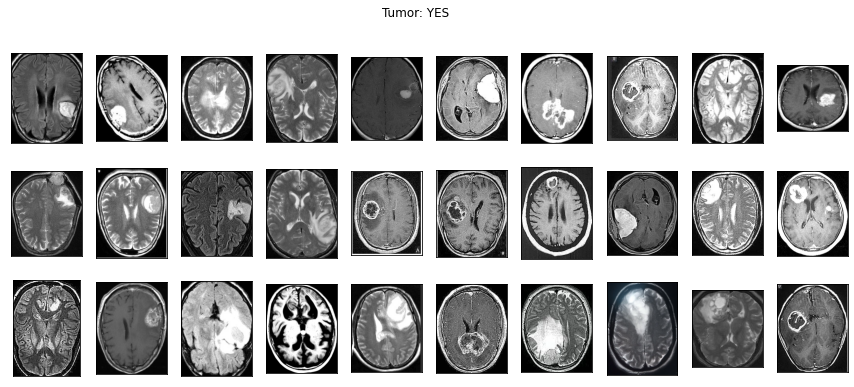

In [43]:
plot_samples(X_train_crop, y_train, labels, 30)

In [44]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [45]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


<h2> Resizing the images </h2>
<p> Now that we have cropped the images, we can resize them without suffering from heavy distortions or resizing artefacts</p>

In [46]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [47]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

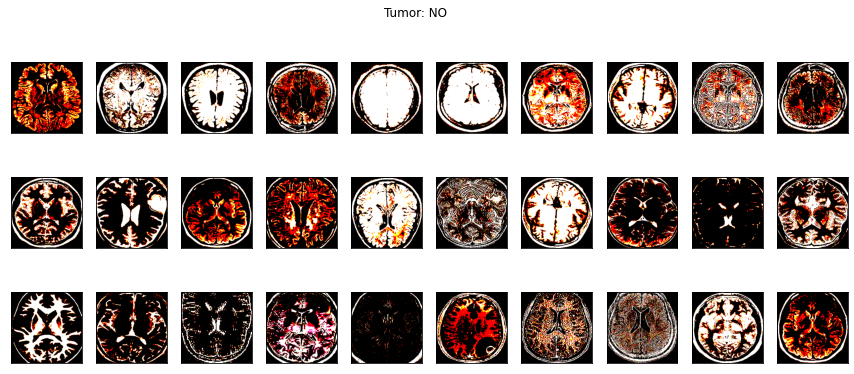

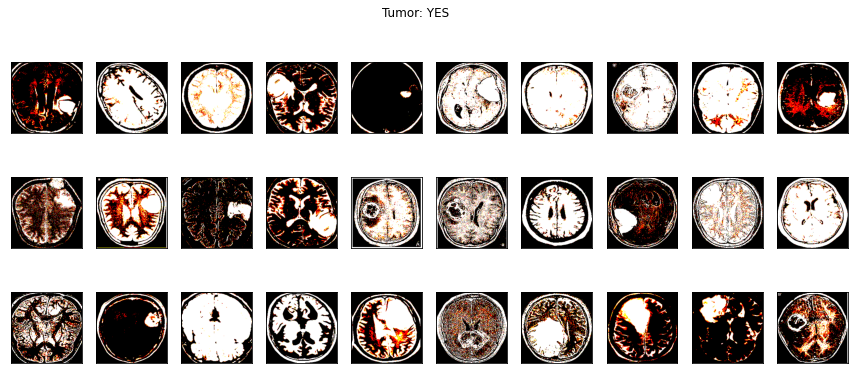

In [48]:
plot_samples(X_train_prep, y_train, labels, 30)

<h2> Image Augmentation </h2>
<p> We will perform data augmentation to increase the number of training samples we have.</p>

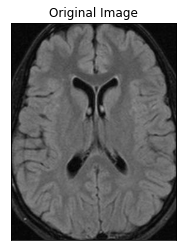

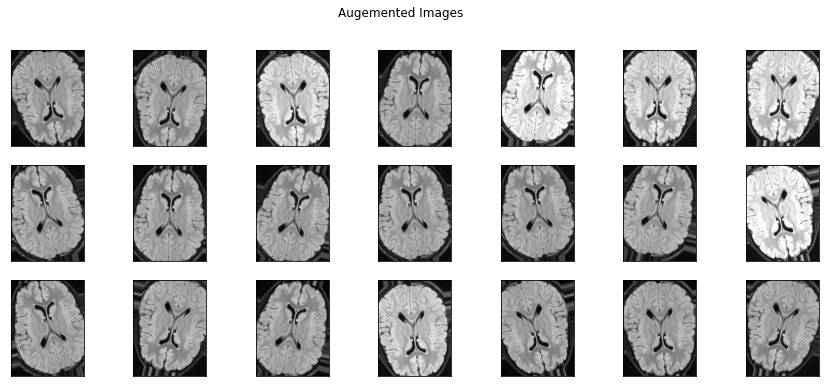

In [49]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [50]:
!rm -rf preview/

In [51]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


 <h2> Let's define our callbacks for the CNN models </h2>

In [52]:
#Callbacks
EPOCHS = 15
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

nClasses = 1

<h2> Creating the models </h2>

<p> As mentioned earlier, in this notebook I am going to create Convolutional Neural Networks of varyiing depths and train them from scatch. </p>


<h2> 2 Layered CNN </h2>

In [53]:
model_2 = Sequential()

model_2.add(Conv2D(16,(3,3),padding='same',input_shape =X_train_prep[0].shape))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_2.add(Conv2D(32,(3,3),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_2.add(Flatten())
model_2.add(Dense(nClasses,activation='sigmoid'))
    
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_3 (Activation)    (None, 112, 112, 32)     

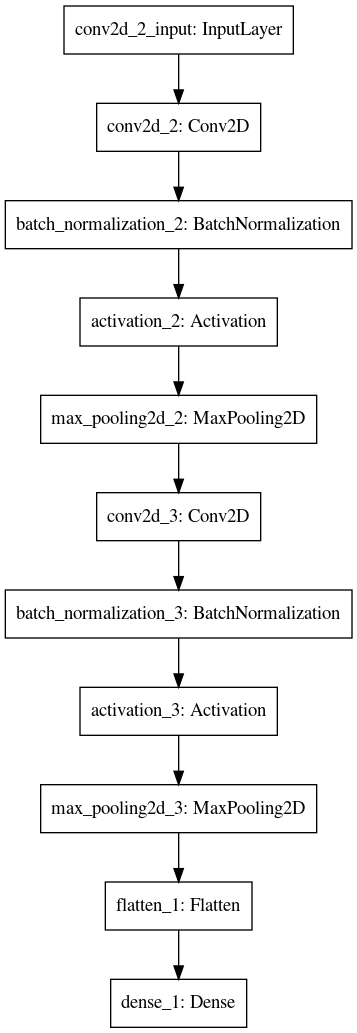

In [54]:
plot_model(model_2)

In [55]:
model_2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','AUC'])

<h2> Let's train the 2 layered CNN </h2>

In [56]:
history = model_2.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
50/50 [==============================] - 25s 485ms/step - loss: 6.8954 - accuracy: 0.5329 - auc: 0.5424 - val_loss: 2.2426 - val_accuracy: 0.6175 - val_auc: 0.6987
Epoch 2/15
50/50 [==============================] - 23s 465ms/step - loss: 1.3669 - accuracy: 0.6092 - auc: 0.6619 - val_loss: 1.3384 - val_accuracy: 0.6000 - val_auc: 0.6767
Epoch 3/15
50/50 [==============================] - 24s 477ms/step - loss: 1.0964 - accuracy: 0.6346 - auc: 0.6842 - val_loss: 1.0282 - val_accuracy: 0.6625 - val_auc: 0.7378
Epoch 4/15
50/50 [==============================] - 24s 475ms/step - loss: 2.2938 - accuracy: 0.5917 - auc: 0.6372 - val_loss: 0.9565 - val_accuracy: 0.7025 - val_auc: 0.7976
Epoch 5/15
50/50 [==============================] - 24s 475ms/step - loss: 0.9312 - accuracy: 0.6762 - auc: 0.7468 - val_loss: 0.8642 - val_accuracy: 0.7100 - val_auc: 0.8012
Epoch 6/15
50/50 [==============================] - 23s 462ms/step - loss: 1.0418 - accuracy: 0.6439 - auc: 0.7136 - val_loss

<h2> Plotting some graphs to visualize the training </h2>

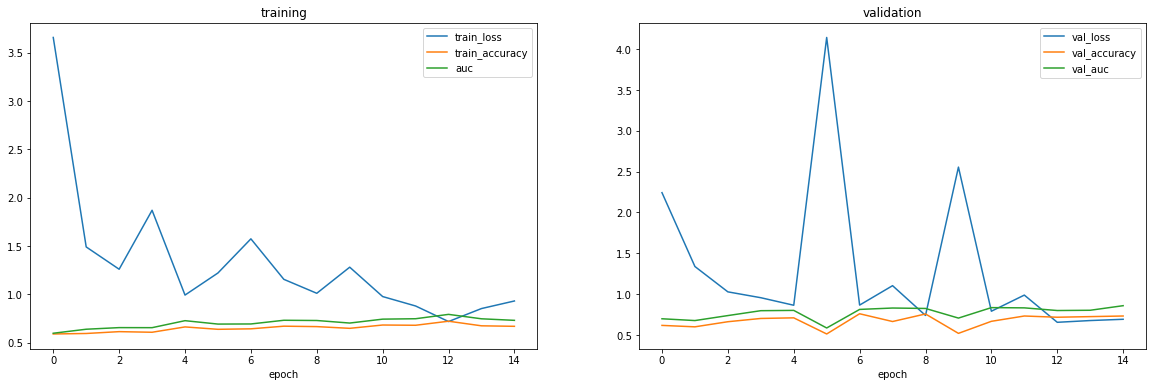

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 , 6))
#plotting the training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('training')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_accuracy' , 'auc'], loc='upper right')

#plotting the validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_auc'])
plt.title('validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy' , 'val_auc'], loc='upper right')
plt.show()


Train Accuracy = 0.74
Val Accuracy = 0.72
Test Accuracy = 0.76


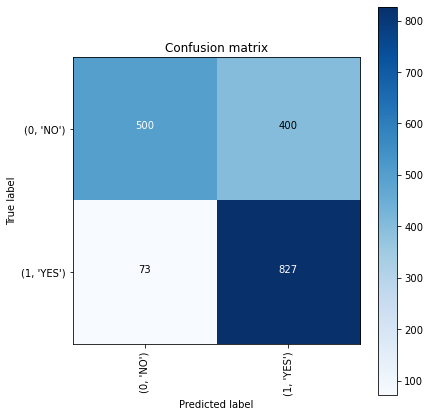

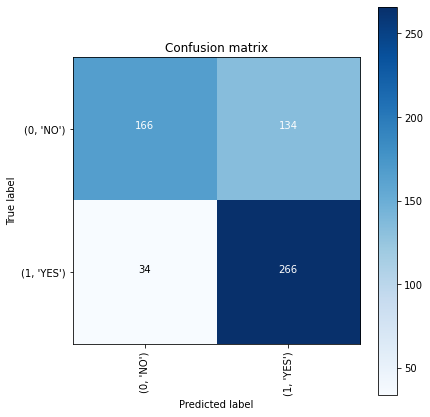

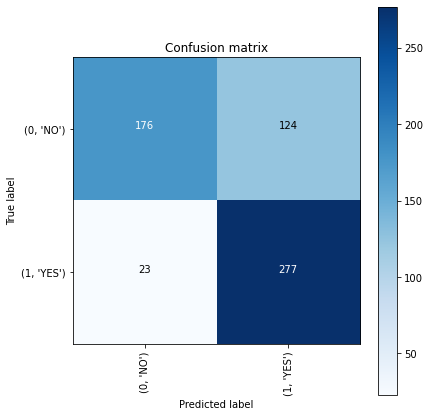

In [58]:
#get the train, test and validation accuracies
train_predictions = model_2.predict(X_train_prep)
val_predictions = model_2.predict(X_val_prep)
test_predictions = model_2.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5
train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data
confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [59]:
test_prob_pred = model_2.predict_proba(X_test_prep)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



In [60]:
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

Accuracy score is : 0.755
Precision score is : 0.7875975889422174
Recall score is : 0.755
F1 Score is : 0.7478551968416148
ROC AUC Score is : 0.8671
Cohen Kappa Score: 0.51
		Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.59      0.71       300
           1       0.69      0.92      0.79       300

    accuracy                           0.76       600
   macro avg       0.79      0.76      0.75       600
weighted avg       0.79      0.76      0.75       600



<h2> 3 Layered CNN </h2>

In [61]:
model_3 = Sequential()

model_3.add(Conv2D(16,(3,3),padding='same',input_shape =X_train_prep[0].shape))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_3.add(Conv2D(32,(3,3),padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_3.add(Conv2D(64,(3,3),padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_3.add(Flatten())
model_3.add(Dense(nClasses,activation='sigmoid'))
    
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_4 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 112, 112, 32)     

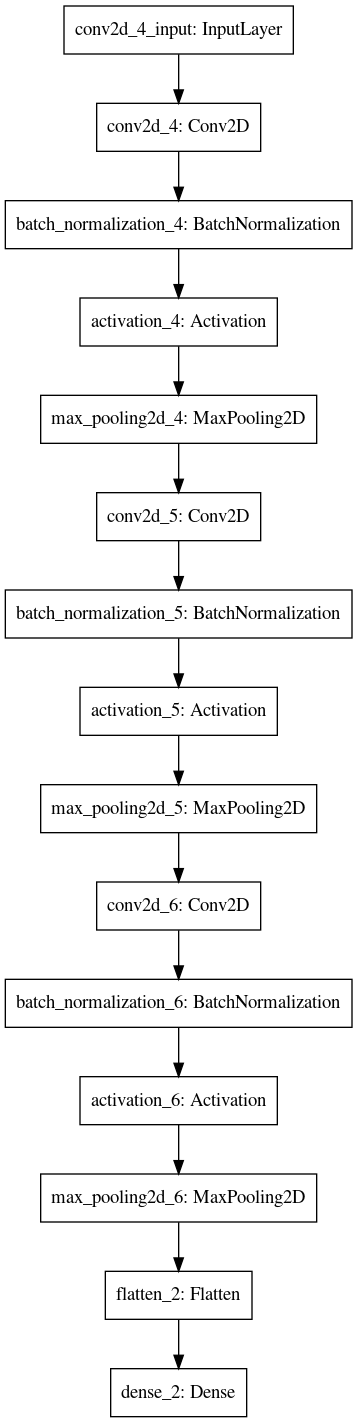

In [62]:
plot_model(model_3)

In [63]:
model_3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','AUC'])
history = model_3.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
50/50 [==============================] - 25s 477ms/step - loss: 1.9646 - accuracy: 0.5412 - auc: 0.5727 - val_loss: 2.2501 - val_accuracy: 0.5700 - val_auc: 0.6943
Epoch 2/15
50/50 [==============================] - 23s 467ms/step - loss: 1.4233 - accuracy: 0.5894 - auc: 0.6336 - val_loss: 3.3111 - val_accuracy: 0.5200 - val_auc: 0.6241
Epoch 3/15
50/50 [==============================] - 23s 453ms/step - loss: 0.7863 - accuracy: 0.6814 - auc: 0.7390 - val_loss: 1.0560 - val_accuracy: 0.6250 - val_auc: 0.8018
Epoch 4/15
50/50 [==============================] - 24s 474ms/step - loss: 0.7170 - accuracy: 0.6766 - auc: 0.7418 - val_loss: 0.7907 - val_accuracy: 0.6575 - val_auc: 0.7972
Epoch 5/15
50/50 [==============================] - 23s 461ms/step - loss: 0.8434 - accuracy: 0.6737 - auc: 0.7338 - val_loss: 1.4366 - val_accuracy: 0.5800 - val_auc: 0.8309
Epoch 6/15
50/50 [==============================] - 23s 469ms/step - loss: 0.8397 - accuracy: 0.6573 - auc: 0.7449 - val_loss

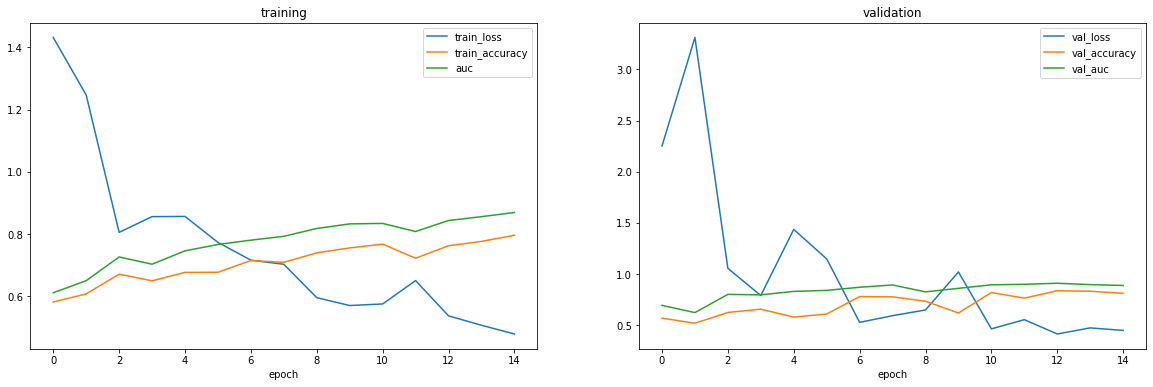

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 , 6))
#plotting the training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('training')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_accuracy' , 'auc'], loc='upper right')

#plotting the validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_auc'])
plt.title('validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy' , 'val_auc'], loc='upper right')
plt.show()

Train Accuracy = 0.81
Val Accuracy = 0.79
Test Accuracy = 0.78


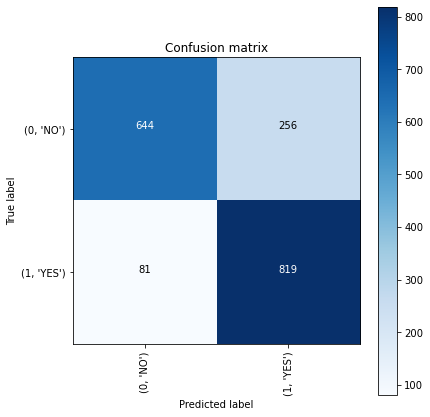

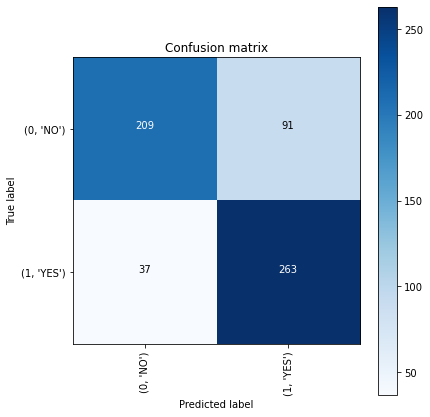

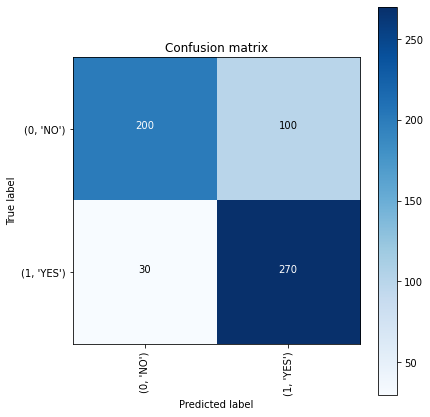

In [65]:
#get the train, test and validation accuracies
train_predictions = model_3.predict(X_train_prep)
val_predictions = model_3.predict(X_val_prep)
test_predictions = model_3.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5
train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data
confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [66]:
test_prob_pred = model_3.predict_proba(X_test_prep)
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



Accuracy score is : 0.7833333333333333
Precision score is : 0.799647473560517
Recall score is : 0.7833333333333333
F1 Score is : 0.7803435651929033
ROC AUC Score is : 0.8905444444444446
Cohen Kappa Score: 0.5666666666666667
		Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.75       300
           1       0.73      0.90      0.81       300

    accuracy                           0.78       600
   macro avg       0.80      0.78      0.78       600
weighted avg       0.80      0.78      0.78       600



<h2> 4 layered CNN </h2>

In [67]:
model_4 = Sequential()

model_4.add(Conv2D(16,(3,3),padding='same',input_shape =X_train_prep[0].shape))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_4.add(Conv2D(32,(3,3),padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_4.add(Conv2D(64,(3,3),padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_4.add(Conv2D(128,(3,3),padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_4.add(Flatten())
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(nClasses,activation='sigmoid'))
    
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 112, 112, 32)     

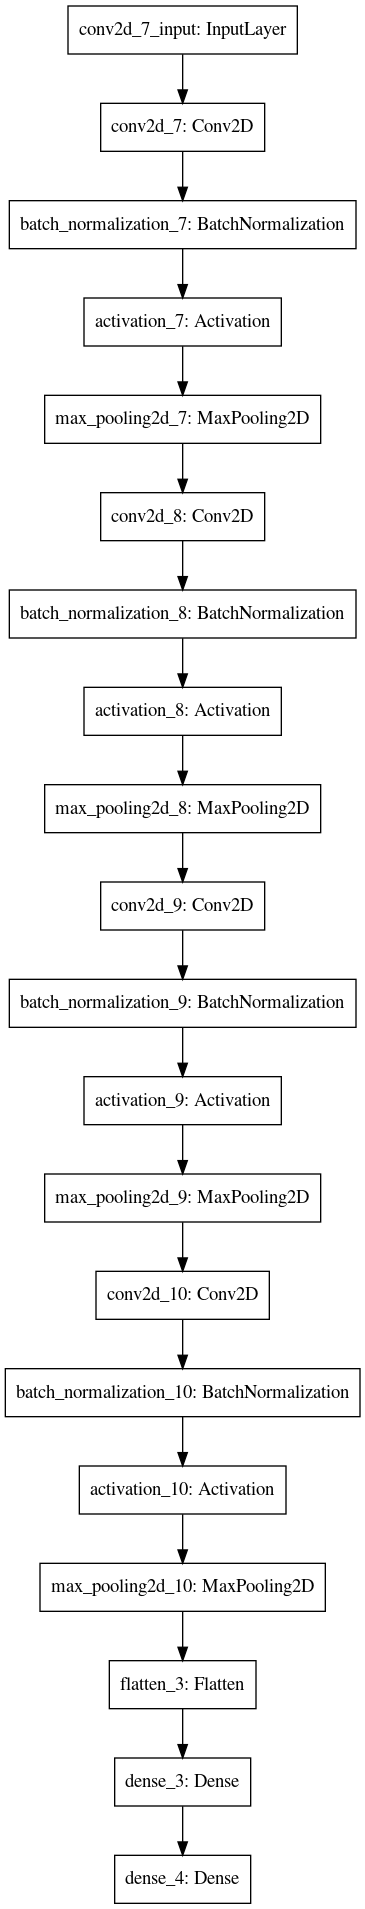

In [68]:
plot_model(model_4)

In [69]:
model_4.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','AUC'])
history = model_4.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
50/50 [==============================] - 25s 486ms/step - loss: 1.5150 - accuracy: 0.5171 - auc: 0.5365 - val_loss: 0.6932 - val_accuracy: 0.4950 - val_auc: 0.5000
Epoch 2/15
50/50 [==============================] - 24s 471ms/step - loss: 0.6932 - accuracy: 0.4931 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5175 - val_auc: 0.5000
Epoch 3/15
50/50 [==============================] - 23s 463ms/step - loss: 0.6932 - accuracy: 0.5058 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5025 - val_auc: 0.5000
Epoch 4/15
50/50 [==============================] - 23s 461ms/step - loss: 0.6931 - accuracy: 0.5255 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5075 - val_auc: 0.5000
Epoch 5/15
50/50 [==============================] - 23s 465ms/step - loss: 0.6930 - accuracy: 0.5420 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5200 - val_auc: 0.5000
Epoch 6/15
50/50 [==============================] - 23s 470ms/step - loss: 0.6931 - accuracy: 0.5056 - auc: 0.5000 - val_loss

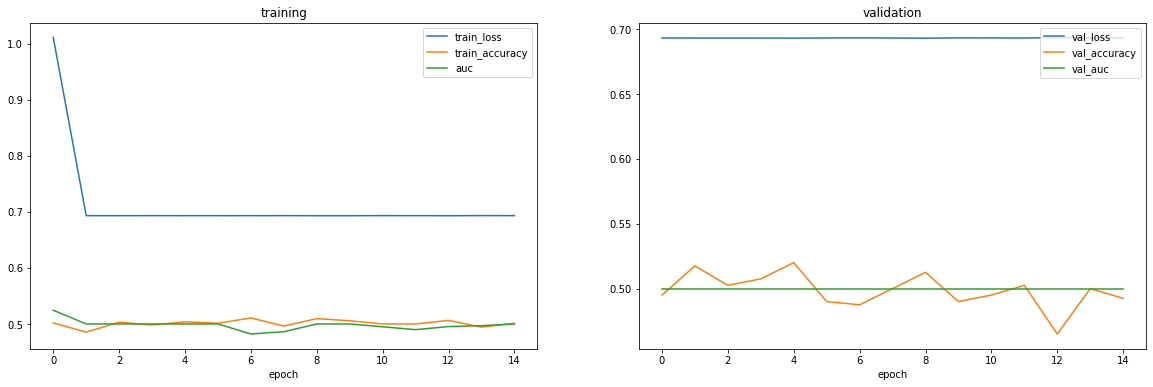

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 , 6))
#plotting the training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('training')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_accuracy' , 'auc'], loc='upper right')

#plotting the validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_auc'])
plt.title('validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy' , 'val_auc'], loc='upper right')
plt.show()

Train Accuracy = 0.50
Val Accuracy = 0.50
Test Accuracy = 0.50


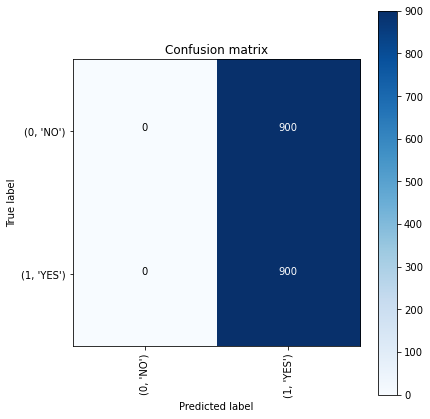

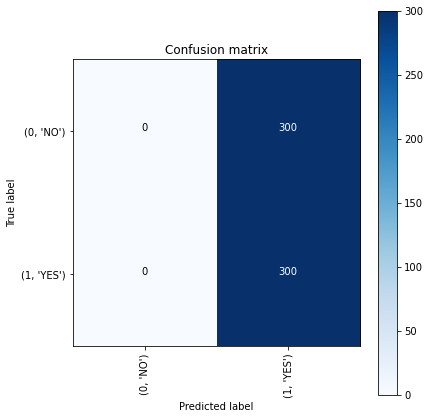

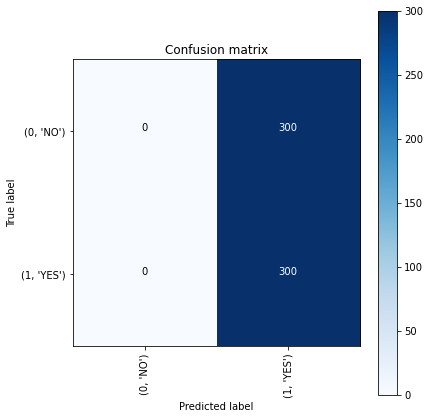

In [71]:
#get the train, test and validation accuracies
train_predictions = model_4.predict(X_train_prep)
val_predictions = model_4.predict(X_val_prep)
test_predictions = model_4.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5
train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data
confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [72]:
test_prob_pred = model_4.predict_proba(X_test_prep)
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



Accuracy score is : 0.5
Precision score is : 0.25
Recall score is : 0.5
F1 Score is : 0.3333333333333333
ROC AUC Score is : 0.5
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

<h2> 5 Layered CNN </h2>

In [73]:
model_5 = Sequential()

model_5.add(Conv2D(16,(3,3),padding='same',input_shape =X_train_prep[0].shape))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_5.add(Conv2D(32,(3,3),padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_5.add(Conv2D(64,(3,3),padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_5.add(Conv2D(128,(3,3),padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_5.add(Conv2D(256,(3,3),padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_5.add(Flatten())
model_5.add(Dense(16, activation='relu'))
model_5.add(Dense(nClasses,activation='sigmoid'))
    
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_11 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_11 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
activation_12 (Activation)   (None, 112, 112, 32)     

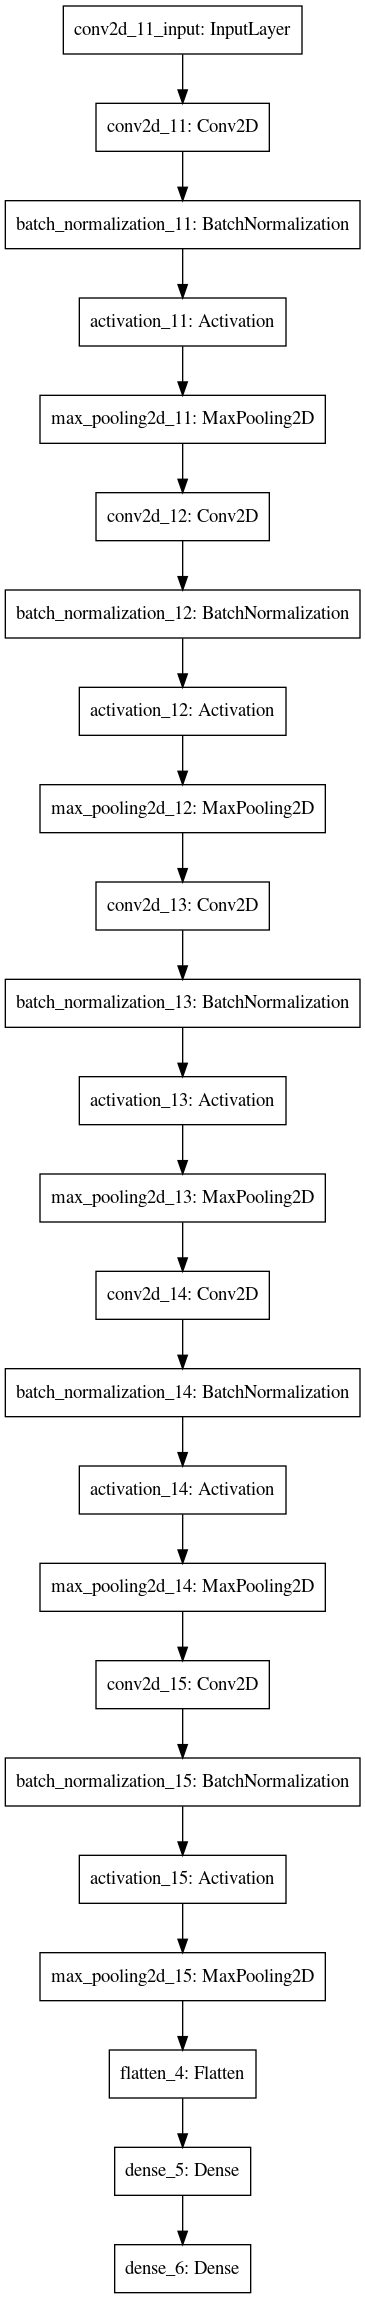

In [74]:
plot_model(model_5)

In [75]:
model_5.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','AUC'])
history = model_5.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
50/50 [==============================] - 25s 473ms/step - loss: 1.4157 - accuracy: 0.5029 - auc: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5200 - val_auc: 0.5000
Epoch 2/15
50/50 [==============================] - 24s 471ms/step - loss: 0.6931 - accuracy: 0.5110 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/15
50/50 [==============================] - 23s 464ms/step - loss: 0.6931 - accuracy: 0.5209 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5050 - val_auc: 0.5000
Epoch 4/15
50/50 [==============================] - 23s 466ms/step - loss: 0.6931 - accuracy: 0.5194 - auc: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4950 - val_auc: 0.5000
Epoch 5/15
50/50 [==============================] - 24s 472ms/step - loss: 0.6931 - accuracy: 0.5019 - auc: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4800 - val_auc: 0.5000
Epoch 6/15
50/50 [==============================] - 24s 469ms/step - loss: 0.6932 - accuracy: 0.4933 - auc: 0.5000 - val_loss

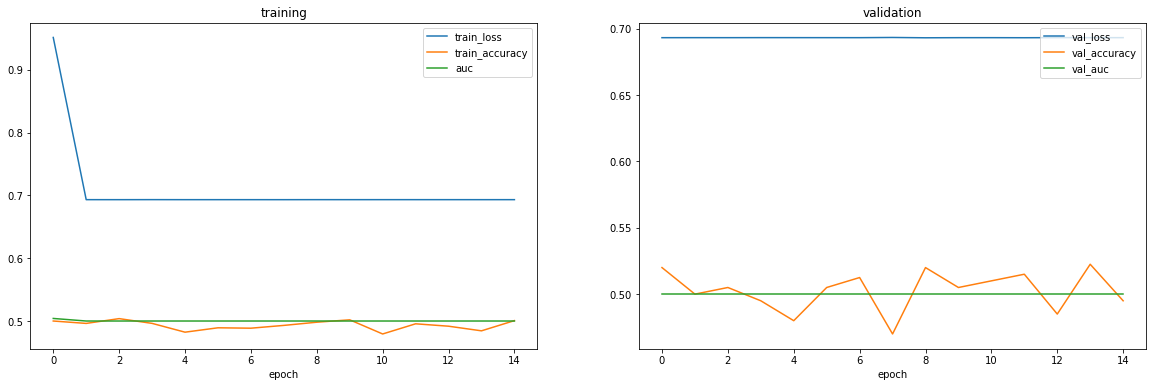

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 , 6))
#plotting the training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('training')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_accuracy' , 'auc'], loc='upper right')

#plotting the validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_auc'])
plt.title('validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy' , 'val_auc'], loc='upper right')
plt.show()

Train Accuracy = 0.50
Val Accuracy = 0.50
Test Accuracy = 0.50


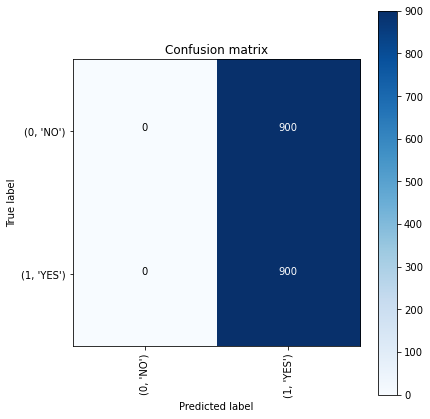

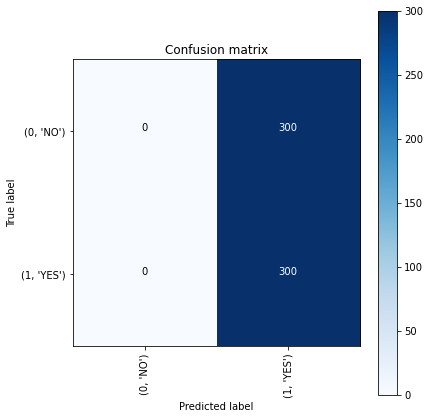

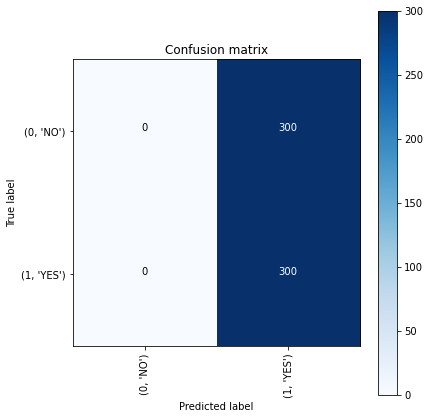

In [77]:
#get the train, test and validation accuracies
train_predictions = model_5.predict(X_train_prep)
val_predictions = model_5.predict(X_val_prep)
test_predictions = model_5.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5
train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data
confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [78]:
test_prob_pred = model_5.predict_proba(X_test_prep)
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



Accuracy score is : 0.5
Precision score is : 0.25
Recall score is : 0.5
F1 Score is : 0.3333333333333333
ROC AUC Score is : 0.5
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

<h2> 6 Layered CNN </h2>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_16 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_16 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_17 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
activation_17 (Activation)   (None, 112, 112, 32)     

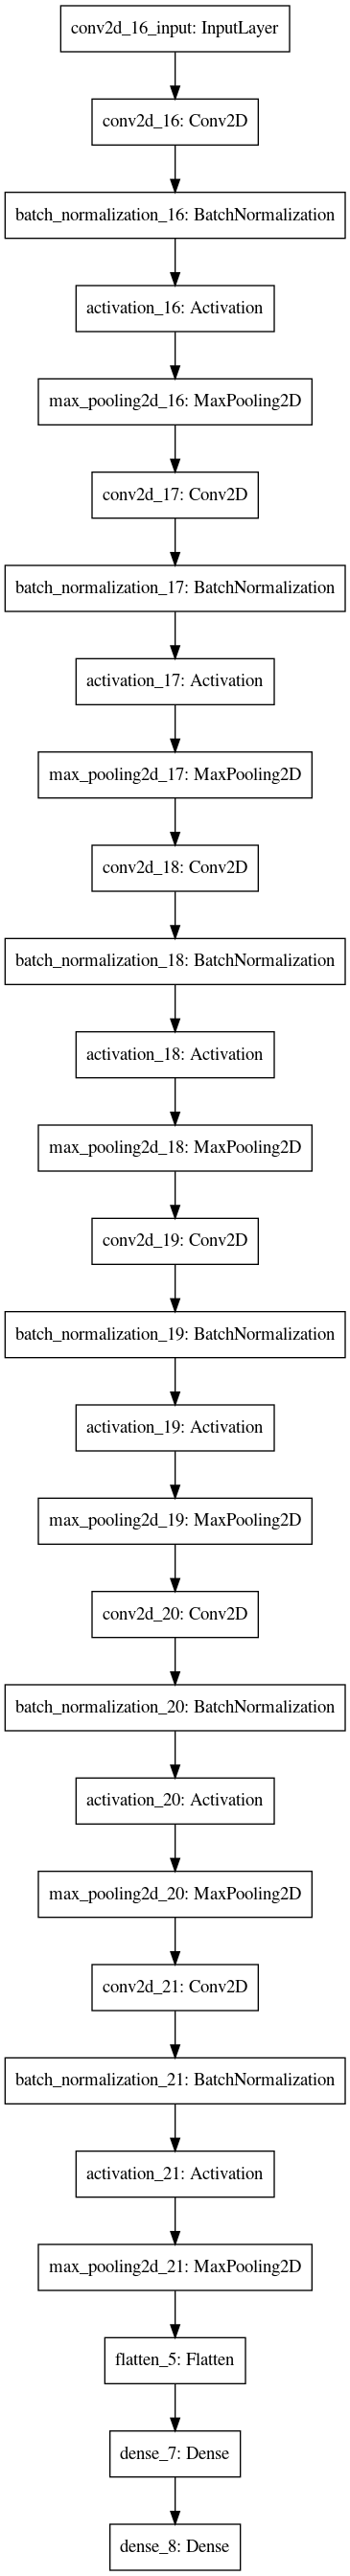

In [79]:
model_6 = Sequential()

model_6.add(Conv2D(16,(3,3),padding='same',input_shape =X_train_prep[0].shape))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_6.add(Conv2D(32,(3,3),padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_6.add(Conv2D(64,(3,3),padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_6.add(Conv2D(128,(3,3),padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_6.add(Conv2D(256,(3,3),padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_6.add(Conv2D(128,(3,3),padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_6.add(Flatten())
model_6.add(Dense(16, activation='relu'))
model_6.add(Dense(nClasses,activation='sigmoid'))
    
model_6.summary()
plot_model(model_6)

In [80]:
model_6.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','AUC'])
history = model_6.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
50/50 [==============================] - 25s 468ms/step - loss: 0.7396 - accuracy: 0.4810 - auc: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/15
50/50 [==============================] - 24s 475ms/step - loss: 0.6932 - accuracy: 0.5382 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5175 - val_auc: 0.5000
Epoch 3/15
50/50 [==============================] - 23s 467ms/step - loss: 0.6932 - accuracy: 0.4920 - auc: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4975 - val_auc: 0.5000
Epoch 4/15
50/50 [==============================] - 23s 456ms/step - loss: 0.6932 - accuracy: 0.4847 - auc: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4975 - val_auc: 0.5000
Epoch 5/15
50/50 [==============================] - 23s 467ms/step - loss: 0.6931 - accuracy: 0.4981 - auc: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4950 - val_auc: 0.5000
Epoch 6/15
50/50 [==============================] - 23s 465ms/step - loss: 0.6931 - accuracy: 0.5013 - auc: 0.5000 - val_loss

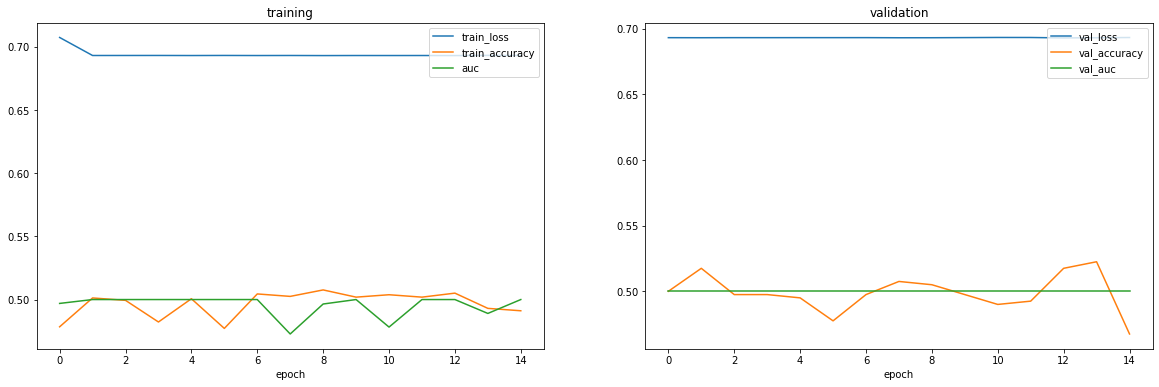

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 , 6))
#plotting the training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('training')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_accuracy' , 'auc'], loc='upper right')

#plotting the validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_auc'])
plt.title('validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy' , 'val_auc'], loc='upper right')
plt.show()

Train Accuracy = 0.50
Val Accuracy = 0.50
Test Accuracy = 0.50


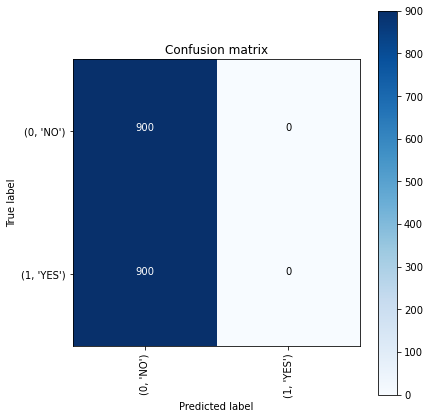

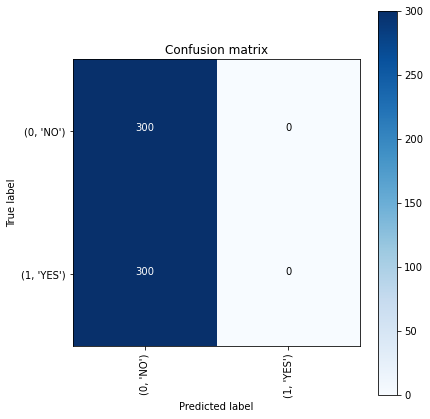

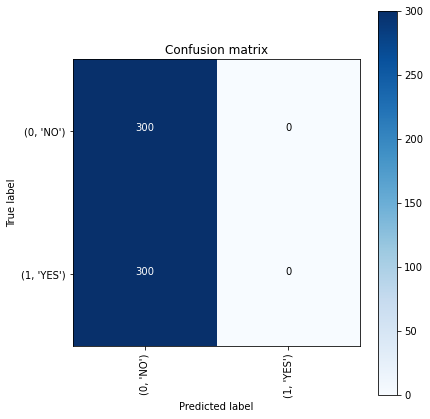

In [82]:
#get the train, test and validation accuracies
train_predictions = model_6.predict(X_train_prep)
val_predictions = model_6.predict(X_val_prep)
test_predictions = model_6.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5
train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data
confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [83]:
test_prob_pred = model_6.predict_proba(X_test_prep)
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



Accuracy score is : 0.5
Precision score is : 0.25
Recall score is : 0.5
F1 Score is : 0.3333333333333333
ROC AUC Score is : 0.5
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       300
           1       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

<h2> 7 Layered CNN </h2>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_22 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_22 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_23 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
activation_23 (Activation)   (None, 112, 112, 32)     

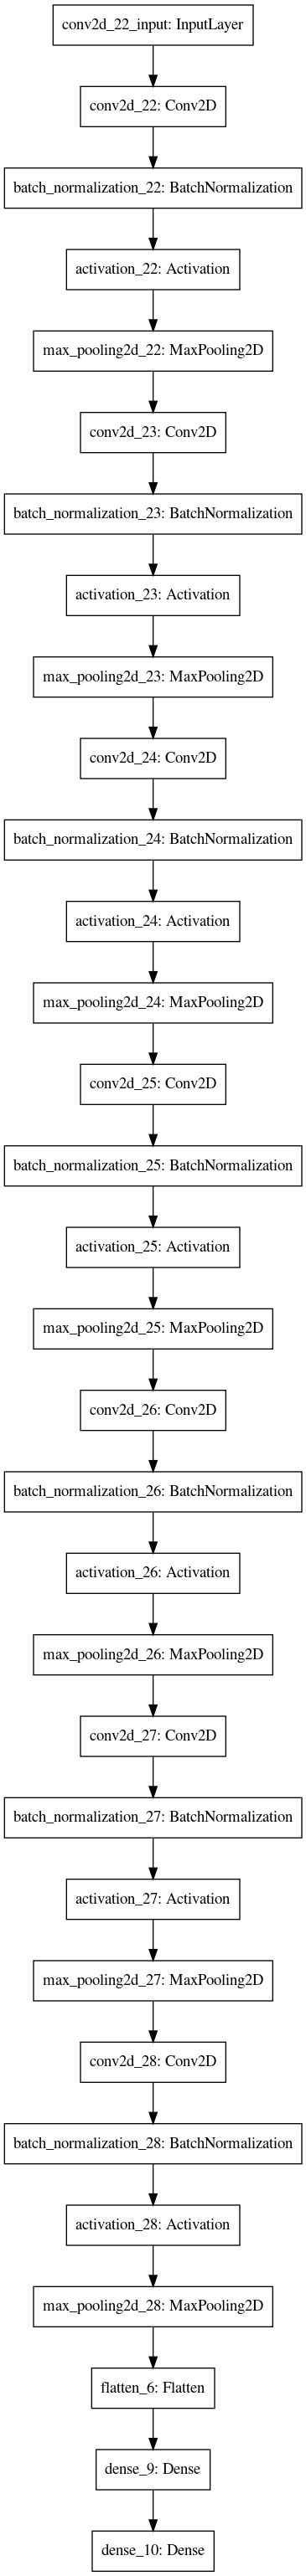

In [84]:
model_7 = Sequential()

model_7.add(Conv2D(16,(3,3),padding='same',input_shape =X_train_prep[0].shape))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_7.add(Conv2D(32,(3,3),padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_7.add(Conv2D(64,(3,3),padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_7.add(Conv2D(128,(3,3),padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_7.add(Conv2D(256,(3,3),padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_7.add(Conv2D(512,(3,3),padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_7.add(Conv2D(128,(3,3),padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_7.add(Flatten())
model_7.add(Dense(16, activation='relu'))
model_7.add(Dense(nClasses,activation='sigmoid'))

model_7.summary()
plot_model(model_7)

In [85]:
model_7.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','AUC'])
history = model_7.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
50/50 [==============================] - 25s 465ms/step - loss: 0.7707 - accuracy: 0.5334 - auc: 0.5449 - val_loss: 0.7593 - val_accuracy: 0.5075 - val_auc: 0.5799
Epoch 2/15
50/50 [==============================] - 23s 471ms/step - loss: 0.6853 - accuracy: 0.5829 - auc: 0.5892 - val_loss: 0.6808 - val_accuracy: 0.5425 - val_auc: 0.6056
Epoch 3/15
50/50 [==============================] - 23s 468ms/step - loss: 0.6765 - accuracy: 0.5838 - auc: 0.6127 - val_loss: 0.6843 - val_accuracy: 0.5875 - val_auc: 0.6875
Epoch 4/15
50/50 [==============================] - 23s 469ms/step - loss: 0.6124 - accuracy: 0.6784 - auc: 0.7301 - val_loss: 0.6224 - val_accuracy: 0.6825 - val_auc: 0.7592
Epoch 5/15
50/50 [==============================] - 23s 455ms/step - loss: 0.5084 - accuracy: 0.7380 - auc: 0.8324 - val_loss: 1.1598 - val_accuracy: 0.5125 - val_auc: 0.6594
Epoch 6/15
50/50 [==============================] - 23s 470ms/step - loss: 0.4771 - accuracy: 0.7721 - auc: 0.8543 - val_loss

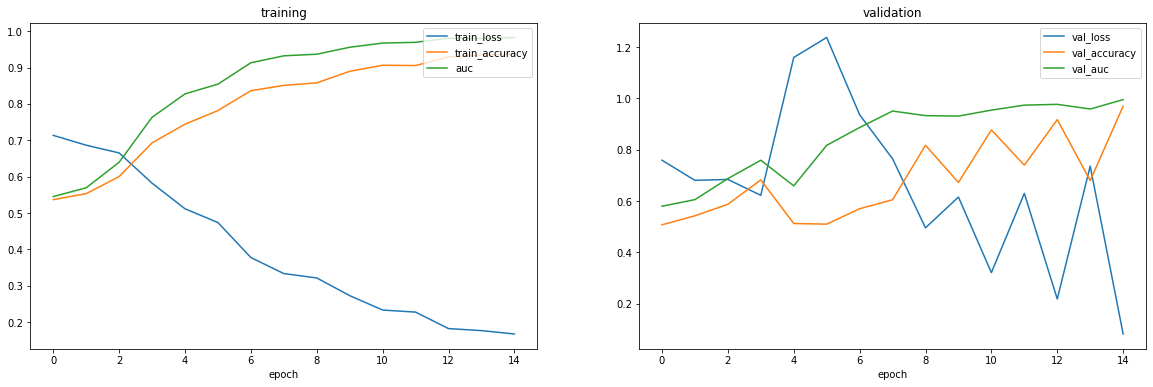

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 , 6))
#plotting the training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('training')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_accuracy' , 'auc'], loc='upper right')

#plotting the validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_auc'])
plt.title('validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy' , 'val_auc'], loc='upper right')
plt.show()

Train Accuracy = 0.97
Val Accuracy = 0.96
Test Accuracy = 0.96


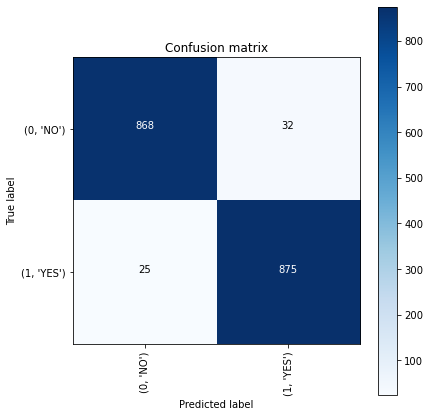

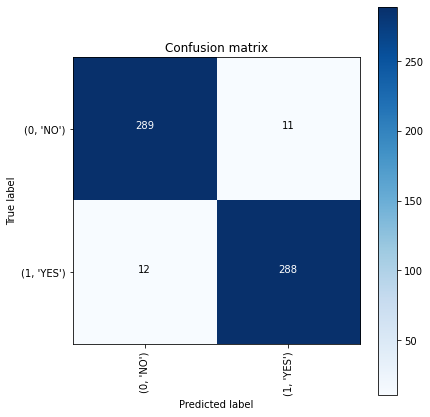

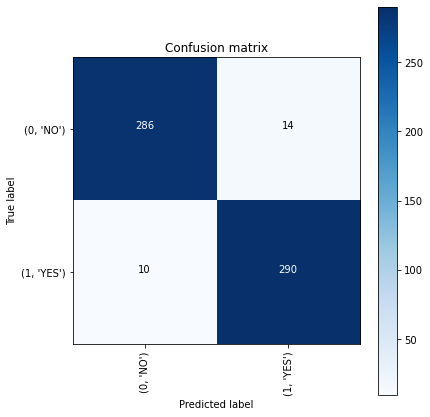

In [87]:
#get the train, test and validation accuracies
train_predictions = model_7.predict(X_train_prep)
val_predictions = model_7.predict(X_val_prep)
test_predictions = model_7.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5
train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data
confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [88]:
test_prob_pred = model_7.predict_proba(X_test_prep)
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



Accuracy score is : 0.96
Precision score is : 0.9600817923186343
Recall score is : 0.96
F1 Score is : 0.9599982221432064
ROC AUC Score is : 0.9943888888888889
Cohen Kappa Score: 0.92
		Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       300
           1       0.95      0.97      0.96       300

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



<h2>8 Layered CNN </h2>

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_29 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_29 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_30 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
activation_30 (Activation)   (None, 112, 112, 32)     

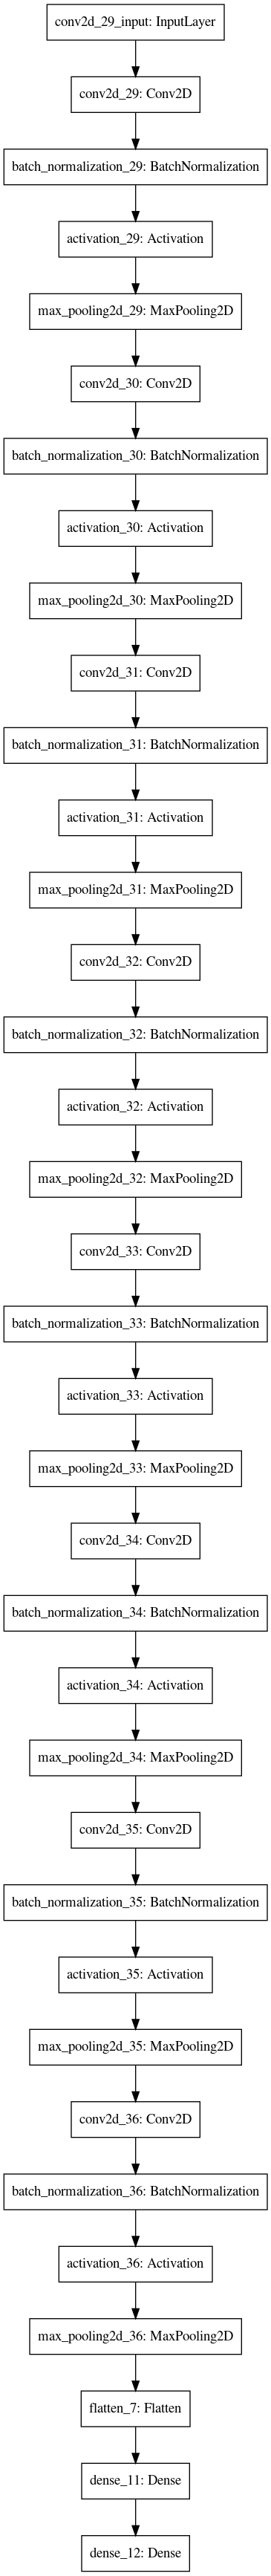

In [89]:
model_8 = Sequential()

model_8.add(Conv2D(16,(3,3),padding='same',input_shape =X_train_prep[0].shape))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Conv2D(32,(3,3),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Conv2D(64,(3,3),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Conv2D(128,(3,3),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Conv2D(256,(3,3),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Conv2D(512,(3,3),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Conv2D(128,(3,3),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Conv2D(64,(3,3),padding='same'))
model_8.add(BatchNormalization())
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model_8.add(Flatten())
model_8.add(Dense(16, activation='relu'))
model_8.add(Dense(nClasses,activation='sigmoid'))

model_8.summary()
plot_model(model_8)

In [90]:
model_8.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','AUC'])
history = model_8.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
50/50 [==============================] - 25s 475ms/step - loss: 0.7279 - accuracy: 0.5485 - auc: 0.5652 - val_loss: 0.6794 - val_accuracy: 0.6200 - val_auc: 0.6653
Epoch 2/15
50/50 [==============================] - 23s 458ms/step - loss: 0.6255 - accuracy: 0.6500 - auc: 0.7106 - val_loss: 0.7376 - val_accuracy: 0.6100 - val_auc: 0.7635
Epoch 3/15
50/50 [==============================] - 24s 471ms/step - loss: 0.5180 - accuracy: 0.7624 - auc: 0.8266 - val_loss: 0.9146 - val_accuracy: 0.6350 - val_auc: 0.8249
Epoch 4/15
50/50 [==============================] - 23s 466ms/step - loss: 0.4710 - accuracy: 0.7847 - auc: 0.8597 - val_loss: 1.9819 - val_accuracy: 0.5475 - val_auc: 0.7682
Epoch 5/15
50/50 [==============================] - 23s 457ms/step - loss: 0.4394 - accuracy: 0.8038 - auc: 0.8790 - val_loss: 0.9618 - val_accuracy: 0.6375 - val_auc: 0.8830
Epoch 6/15
50/50 [==============================] - 23s 465ms/step - loss: 0.3371 - accuracy: 0.8598 - auc: 0.9321 - val_loss

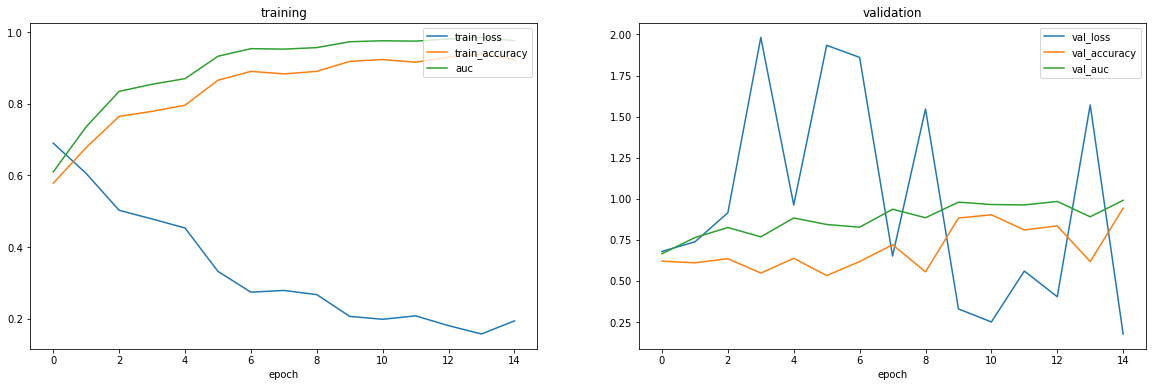

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 , 6))
#plotting the training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('training')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_accuracy' , 'auc'], loc='upper right')

#plotting the validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_auc'])
plt.title('validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_accuracy' , 'val_auc'], loc='upper right')
plt.show()

Train Accuracy = 0.94
Val Accuracy = 0.94
Test Accuracy = 0.94


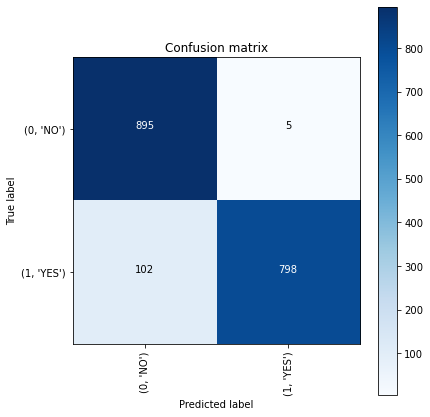

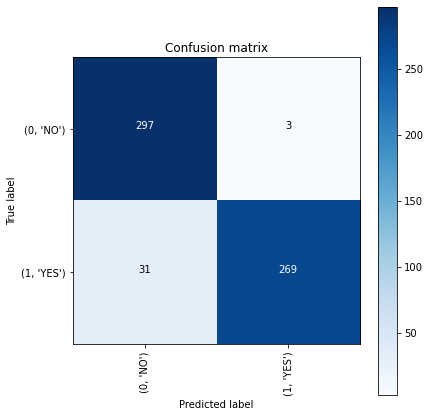

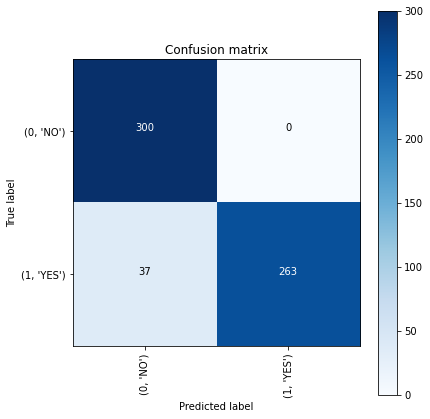

In [92]:
#get the train, test and validation accuracies
train_predictions = model_8.predict(X_train_prep)
val_predictions = model_8.predict(X_val_prep)
test_predictions = model_8.predict(X_test_prep)

#Binarizing all the outputs by setting the threshold to 0.5
train_predictions = [1 if x>0.5 else 0 for x in train_predictions]
val_predictions = [1 if x>0.5 else 0 for x in val_predictions]
test_predictions = [1 if x>0.5 else 0 for x in test_predictions]

#Calculating the accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Train Accuracy = %.2f' % train_accuracy)
print('Val Accuracy = %.2f' % val_accuracy)
print('Test Accuracy = %.2f' % test_accuracy)

#Plotting the confusion matrix on the test data
confusion_mtx = confusion_matrix(y_train, train_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_val, val_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

confusion_mtx = confusion_matrix(y_test, test_predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [93]:
test_prob_pred = model_8.predict_proba(X_test_prep)
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, test_predictions))
print('Precision score is :', metrics.precision_score(y_test, test_predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, test_predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, test_predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, test_prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, test_predictions))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, test_predictions))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



Accuracy score is : 0.9383333333333334
Precision score is : 0.9451038575667655
Recall score is : 0.9383333333333334
F1 Score is : 0.9380979335305648
ROC AUC Score is : 0.9875333333333334
Cohen Kappa Score: 0.8766666666666667
		Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       300
           1       1.00      0.88      0.93       300

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600



<h2>Conclusion</h2>

<p> The larger models could have performed better with dropouts, learning rate scheduler, greater number of training samples and more number of epochs. Due to several constraints, I was unable to try all of these out. But will try them all some time in the future !! <p>

In [94]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP